# Build a more capable LLM powered chatbot using LangGraph and web search tool
In this first tutorial of how to use LangGraph, we will build a more capable LLM powered chatbot using LangGraph and web search tool, to find relevant information and provide better responses to users, without being limited to data used for training the llm.

# Summary
- Installations
- Setting environment variables
- Importing necessary packages
- Creating our chatbot using LangGraph to answer questions

# Installations

In [ ]:
pip install -U langgraph langchain_openai langchain-community tavily-python

# Set environment variables

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

# Import necessary packages

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults

# Define and use tavily search tool

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

The results are page summaries our chat bot can use to answer questions.

# Create a `StateGraph`

The first thing you do when you define a graph is define the `State` of the graph using the `StateGraph` object.

A `StateGraph` object defines the structure of our chatbot as a "state machine".

The `State` consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state.

In our example `State` is a `TypedDict` with a single key: `messages`.

The `messages` key is annotated with the `add_messages` reducer function, which tells `LangGraph` to append new messages to the existing list, rather than overwriting it.

`State` keys without an annotation will be overwritten by each update, storing the most recent value.

In [ ]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

So now our graph knows two things:

- Every `node` we define will receive the current `State` as input and return a value that updates that state.

- `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.

Next, add a `chatbot` node. Nodes represent units of work. They are typically regular python functions.

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Notice how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key `messages`. This is the basic pattern for all `LangGraph` node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.



Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

In this cell, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Now in the next cell we'll use conditional edges using `if` statement, to route to different nodes depending on the current graph state.

In our case, the condition either route to `tools` if tool calls are present or to `__end__` if not.
When the graph transitions to `__end__`, it has no more tasks to complete and ceases execution.

So the function `root_tools` receives the current graph `state` and returns a string or a list of strings indicating which node or nodes to call next.
This is done by checking the tool_calls in the chatbot's output.
Again this will will be replaced by a prebuilt `tools_condition` function later.

After that, we add the function to the graph using `add_conditional_edges`

Finally, we add tools-chatbot and start-chatbot edges to the graph

it's to be noticed guys that as the condition can return `__end__`, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

In [ ]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Let's visualize the graph we've built now using the `get_graph` method

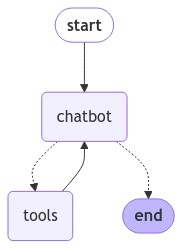

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

In [ ]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: [{"url": "https://www.langchain.com/langgraph", "content": "LangGraph - LangChain ... LangGraph"}, {"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "Announcing LangGraph v0.1 & LangGraph Cloud: Running ..."}]
Assistant: LangGraph appears to be associated with LangChain, a company focused on developing tools and infrastructure for working with language models. Here are some insights based on the search results:

1. **LangGraph**: It is likely a product or service offered by LangChain. The specifics about what LangGraph does weren't detailed in the search snippets, but it could involve tools or frameworks for working with language models.

2. **LangGraph Cloud**: This seems to be a cloud-based offering, possibly a platform to run and manage language models or related applications more efficiently.

To get more detailed information, you can visit:
- [LangGraph on LangChain's website](https://www.langchain.com/langgraph)
- [Announcement of LangGraph 

# Congratulations

Congrats guys! You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries. To inspect all the steps your agent just took, check out this LangSmith trace. Let me know if you need a video on this.

Now the problem here is that our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add memory to address this.

# Sources
https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot